In [1]:
"""We define the class for simulating the SSN model."""

import torch
import matplotlib.pyplot as plt
import math
import spectre.model
import spectre.spectrum_general
from spectre.spectrum_general import matrix_solution
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import recursive_solution
from spectre.model import SSN
import numpy as np
import os

os.chdir("..")
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"figures/SSN/"

In [2]:
"""Define the colors for the different methods"""

color_recursive = "#FFA353"
color_elementwise = "#095400"
color_matrix = "#1B3B9D"
color_sim = "k"

linewidth_recursive = 12
linewidth_elementwise = 3.5
marker_matrix = 8
simulation_marker = 12

font_size = 28

In [3]:
"""Define the SSN circuit"""

N = 11  # dim of the system
length = 9
c = 50
eta = 0.01  # S.D. of the noise
model = SSN(N=N, length=length, c=c, eta=eta)  # create the SSN object

In [4]:
"""Define the simulation parameters"""

ndivs = 50
n_points = int(1e5)
time = 50
dt = 1e-4

In [5]:
"""Define the frequency vectors"""

min_freq = 1
max_freq = 1000
n_freq_mat = 60
n_freq_rat = 1000

"""Define the frequency vectors for the matrix and rational solutions"""
freq_mat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_mat)
freq_rat = torch.logspace(np.log10(min_freq), np.log10(max_freq), n_freq_rat)

In [6]:
"""Find auto-spectra using different schemes"""

idx = N // 2

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
psd_matrix, _ = mat_model.auto_spectrum(idx, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
psd_rational, _ = rat_model.auto_spectrum(idx, freq_rat)

"""Analytical solution (recursive algorithm)"""
recursive_model = recursive_solution(model.J, model.L, model.S)
psd_recursive, _ = recursive_model.auto_spectrum(idx, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
psd_sim, f = sim_model.simulation_spectrum(
    i=idx, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

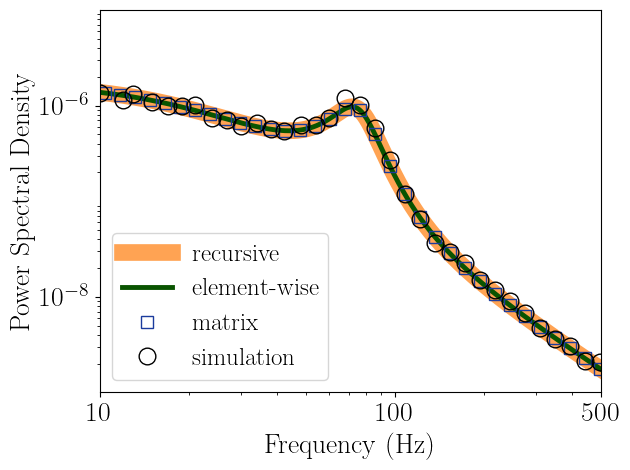

In [7]:
plt.figure(1)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.loglog(
    freq_rat,
    psd_recursive,
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.loglog(
    freq_rat,
    psd_rational,
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.loglog(
    freq_mat,
    psd_matrix,
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="lower left")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Power Spectral Density", fontsize=20)
plt.xticks([10, 100, 500], ["10", "100", "500"], fontsize=20)
plt.yticks([1e-10, 1e-8, 1e-6], fontsize=20)
plt.xlim([10, 500])
plt.ylim([1e-9, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "psd_ssn.svg", format="svg", dpi=1200)
plt.show()

In [8]:
"""Plot the cross-spectrum between the two center neurons"""

i = N // 2
j = i + 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
cpsd_matrix, _ = mat_model.cross_spectrum(i, j, freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
cpsd_rational, _ = rat_model.cross_spectrum(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
# recursive_model = recursive_solution(model.J, model.L, model.S)
cpsd_recursive, _ = recursive_model.cross_spectrum(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
cpsd_sim, f = sim_model.simulation_spectrum(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

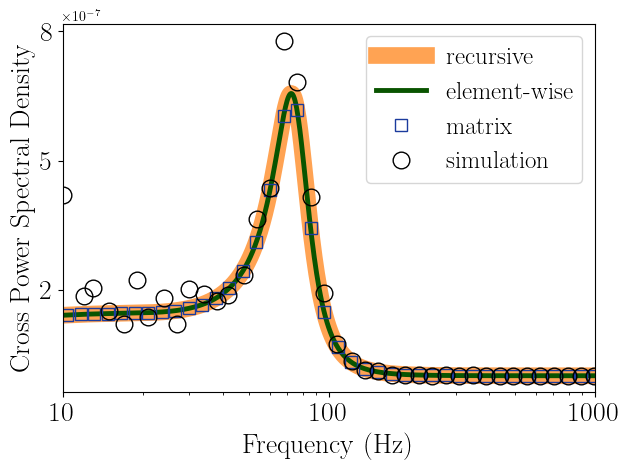

In [9]:
plt.figure(2)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat,
    torch.abs(cpsd_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.semilogx(
    freq_rat,
    torch.abs(cpsd_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.semilogx(
    freq_mat,
    torch.abs(cpsd_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.semilogx(
    f[idx_closest],
    torch.abs(cpsd_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="upper right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Cross Power Spectral Density", fontsize=20)
plt.xticks([10, 100, 1000], ["10", "100", "1000"], fontsize=20)
plt.yticks([2e-7, 5e-7, 8e-7], fontsize=20)
plt.xlim([10, freq_mat[-1]])
# plt.ylim([1e-10, 1e-5])
plt.tight_layout()
plt.savefig(fileloc + "cpsd_ssn_absolute.svg", format="svg", dpi=1200)
plt.show()

In [10]:
"""Plot the coherence between the two central neurons"""

i = N // 2
j = i + 1

"""Analytical solution (matrix)"""
mat_model = matrix_solution(model.J, model.L, model.S)
coh_matrix, _ = mat_model.coherence(i=i, j=j, freq=freq_mat)

"""Analytical solution (elementwise)"""
rat_model = element_wise(model.J, model.L, model.S)
coh_rational, _ = rat_model.coherence(i, j, freq_rat)

"""Analytical solution (recursive algorithm)"""
# recursive_model = recursive_solution(model.J, model.L, model.S)
coh_recursive, _ = recursive_model.coherence(i, j, freq_rat)

"""Simulation solution"""
sim_model = sim_solution(model)
coh_sim, f = sim_model.simulation_coherence(
    i=i, j=j, ndivs=ndivs, n_points=n_points, time=time, dt=dt
)

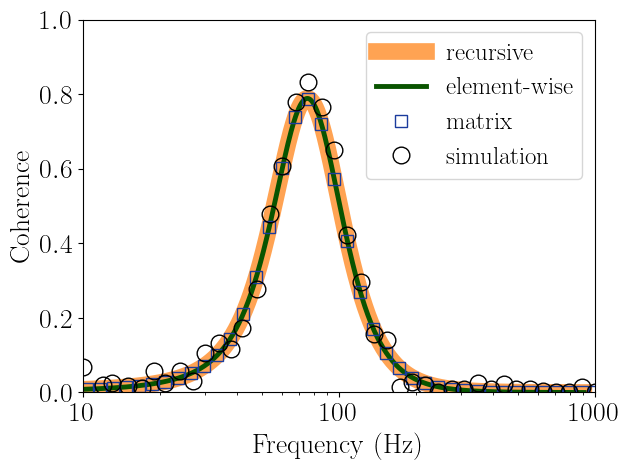

In [11]:
plt.figure(3)
idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
plt.semilogx(
    freq_rat,
    torch.abs(coh_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
plt.semilogx(
    freq_rat,
    torch.abs(coh_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
plt.semilogx(
    freq_mat,
    torch.abs(coh_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
plt.semilogx(
    f[idx_closest],
    torch.abs(coh_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
plt.legend(fontsize=18, loc="upper right")
plt.xlabel("Frequency (Hz)", fontsize=20)
plt.ylabel("Coherence", fontsize=20)
plt.xticks([10, 100, 1000], ["10", "100", "1000"], fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.xlim([10, freq_mat[-1]])
plt.ylim([0, 1])
plt.tight_layout()
plt.savefig(fileloc + "coh_ssn.svg", format="svg", dpi=1200)
plt.show()

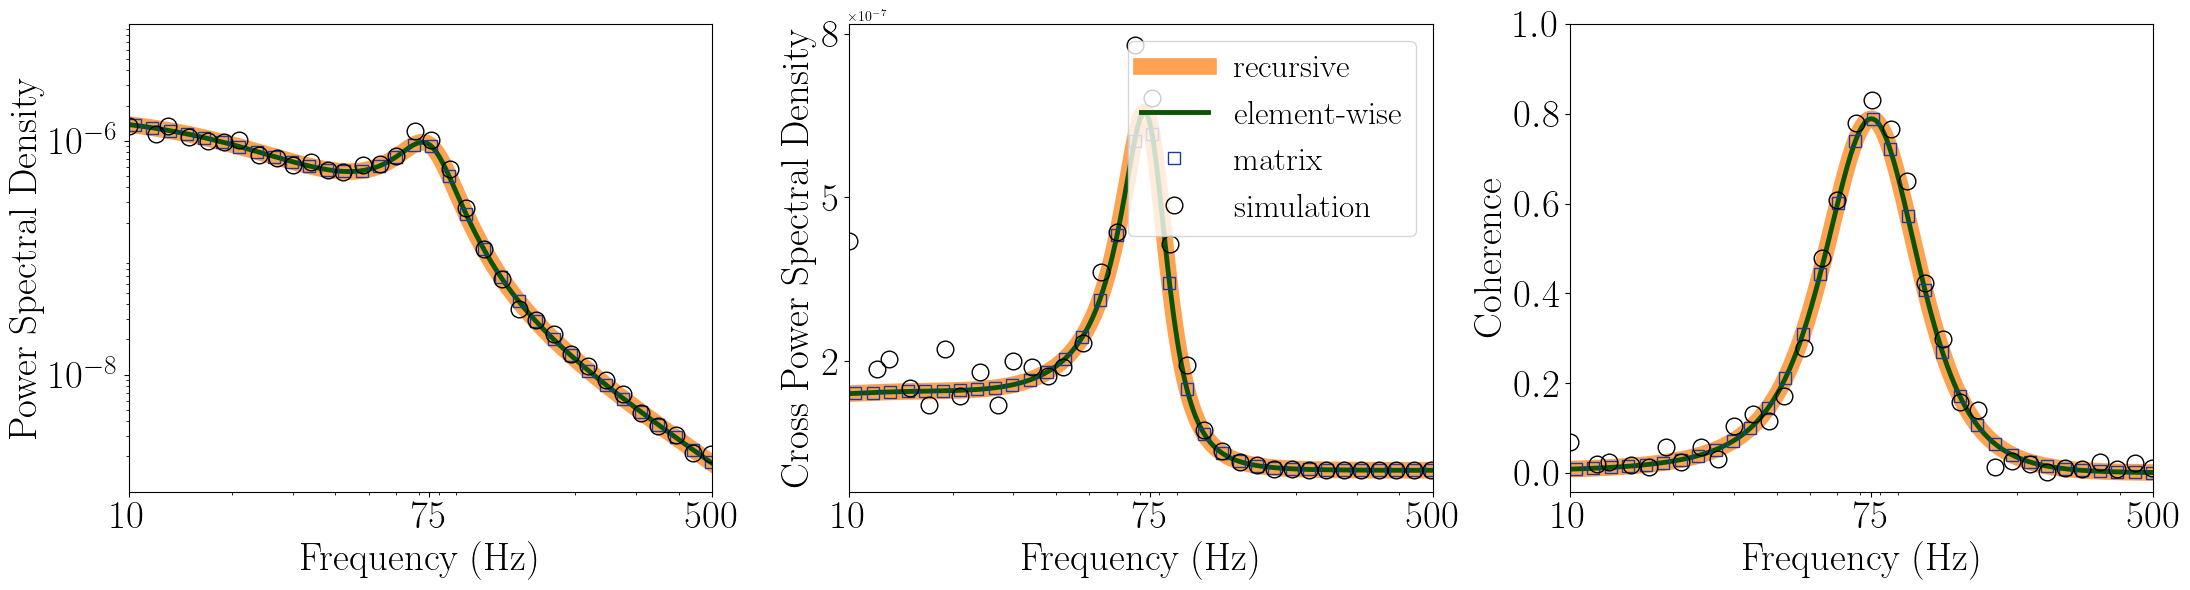

In [12]:
"""Combined figures"""

fig, ax = plt.subplots(1, 3, figsize=(22, 6))

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[0].loglog(
    freq_rat,
    psd_recursive,
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[0].loglog(
    freq_rat,
    psd_rational,
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[0].loglog(
    freq_mat,
    psd_matrix,
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[0].loglog(
    f[idx_closest],
    psd_sim[idx_closest],
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
# ax[0].legend(fontsize=18, loc='lower left')
ax[0].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[0].set_ylabel("Power Spectral Density", fontsize=font_size)
ax[0].set_xticks([10, 75, 500], ["10", "75", "500"])
ax[0].set_yticks([1e-10, 1e-8, 1e-6])
ax[0].tick_params(axis="x", labelsize=font_size)
ax[0].tick_params(axis="y", labelsize=font_size)
ax[0].set_xlim([10, 500])
ax[0].set_ylim([1e-9, 1e-5])

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[1].semilogx(
    freq_rat,
    torch.abs(cpsd_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[1].semilogx(
    freq_rat,
    torch.abs(cpsd_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[1].semilogx(
    freq_mat,
    torch.abs(cpsd_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[1].semilogx(
    f[idx_closest],
    torch.abs(cpsd_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
ax[1].legend(fontsize=24, loc="upper right")
ax[1].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[1].set_ylabel("Cross Power Spectral Density", fontsize=font_size)
ax[1].set_xticks([10, 75, 500], ["10", "75", "500"])
ax[1].set_yticks([2e-7, 5e-7, 8e-7])
ax[1].tick_params(axis="x", labelsize=font_size)
ax[1].tick_params(axis="y", labelsize=font_size)
ax[1].set_xlim([10, 500])
# ax[1].set_ylim([1e-10, 1e-5])

idx_closest = torch.unique(torch.abs(f[1:, None] - freq_mat).argmin(axis=0)) + 1
ax[2].semilogx(
    freq_rat,
    torch.abs(coh_recursive),
    label="recursive",
    linewidth=linewidth_recursive,
    color=color_recursive,
)
ax[2].semilogx(
    freq_rat,
    torch.abs(coh_rational),
    label="element-wise",
    linewidth=linewidth_elementwise,
    color=color_elementwise,
)
ax[2].semilogx(
    freq_mat,
    torch.abs(coh_matrix),
    label="matrix",
    linewidth=0,
    marker="s",
    markerfacecolor="none",
    markersize=marker_matrix,
    color=color_matrix,
)
ax[2].semilogx(
    f[idx_closest],
    torch.abs(coh_sim[idx_closest]),
    label="simulation",
    linewidth=0,
    marker="o",
    markersize=simulation_marker,
    markerfacecolor="none",
    color=color_sim,
)
# ax[2].legend(fontsize=18, loc='upper right')
ax[2].set_xlabel("Frequency (Hz)", fontsize=font_size)
ax[2].set_ylabel("Coherence", fontsize=font_size)
ax[2].set_xticks([10, 75, 500], ["10", "75", "500"])
ax[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax[2].tick_params(axis="x", labelsize=font_size)
ax[2].tick_params(axis="y", labelsize=font_size)
ax[2].set_xlim([10, 500])
# ax[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(fileloc + "combined_SSN.svg", format="svg", dpi=1200)
plt.show()